In [1]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
from sklearn.datasets import make_classification
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import math
from sklearn.model_selection import TimeSeriesSplit
#from sklearn.linear_model import PoissonRegressor
#from sklearn.linear_model import TweedieRegressor
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Demo for Prototype

In [5]:
def LASSOCV_Selection(X, Y, n_CV):
    
    '1. set up cross validation argument for Lasso CV model to tune the parameter of penalised term automatedly.'
    '2. Fit the data into Lasso CV model and obtain the selected/important features.'
    tscv = TimeSeriesSplit(n_splits = n_CV) #Time series split for time series data only.
    lassocv = LassoCV(cv = tscv)
    lassocv.fit(X, Y)
    lasso_selector = SelectFromModel(estimator = lassocv, 
                          prefit = True, 
                          max_features = 10)

    lasso_index = lasso_selector.get_support(indices = True)
    
    '''
    #Second method for step 1 and 2> The version without preserving infor,ation about lasso(cv) model.
    #It is used when there is no need to realise the path and parameter of Lasso CV used.
    lasso_selector = SelectFromModel(LassoCV(cv = tscv), max_features = 10)
    lasso_selector.fit(X, Y)
    lasso_index = lasso_selector.get_support(indices = True)
    print('For modelling extraction, the impactful features are:', lasso_index)
    '''
    
    '3. For interpretation, fit the selected features into GLM - Poisson - model.'
    'Note: It is considered that the esitmation from LASSO model can never or seldom be interpreted but prediction.'
    selected_feature = X.iloc[:, lasso_index]
    selected_feature1 = sm.add_constant(selected_feature) # adding a constant
    poisson_model = sm.GLM(Y, selected_feature1, family = sm.families.Poisson())
    result = poisson_model.fit()
    
    #Extract the exact coefficient values and preserve it into an array - for plotting.
    coef = []
    for v in range(1, len(lasso_index)+1):
        coef.append(result.params.values[v])
    coef = np.array(coef) #Final outcomes formatted in array.
    
    '4. Plot the estimated coefficient'
    #Plot the estimated coefficient.
    dset = pd.DataFrame()
    dset['attr'] = X.columns[lasso_index]
    dset['Coefficient'] = coef.T #Transform array by replacing column/row by row/column.
    dset = dset.sort_values(by = 'Coefficient', ascending=False)

    plt.figure(figsize = (9, 12))
    plt.yticks(fontsize = 11)
    plt.barh(y = dset['attr'], width = dset['Coefficient'], color = '#1976D2')
    #plt.title('Test ', fontsize=20, fontweight='bold', pad=20)
    plt.xlabel('Coefficient', fontsize = 14, labelpad = 20)
    plt.ylabel('Name of Important Features', fontsize = 14, labelpad = 20)
    plt.show()
    
    '5. Plot the resulting probability'
    #Probability transformation: http://www.haowang.pw/blog/Poisson-Coefficient-Interpretation/
    prob = []
    for i in range(len(coef.T)):
        prob_value = math.exp(coef.T[i]) - 1 
        prob.append(prob_value)
        prob_arr = np.array(prob) #Must transform into array to plot against feature neame.

    dset['Prob'] = prob_arr
    dset = dset.sort_values(by = 'Coefficient', ascending = False)

    plt.figure(figsize = (9, 12))
    plt.yticks(fontsize = 11)
    plt.barh(y = dset['attr'], width=dset['Prob'], color='#1976D2')
    #plt.title('Test ', fontsize=20, fontweight='bold', pad=20)
    plt.xlabel('P(Y|factor)', fontsize = 14, labelpad = 20)
    plt.ylabel('Name of Important Features', fontsize = 14, labelpad=20)
    plt.show()

In [70]:
X, Y = make_classification(n_samples=1000, n_features=30, n_classes = 10, n_clusters_per_class = 1,
                           n_informative = 4, random_state = 1)

X = pd.DataFrame(X)
Y = pd.DataFrame(Y)

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


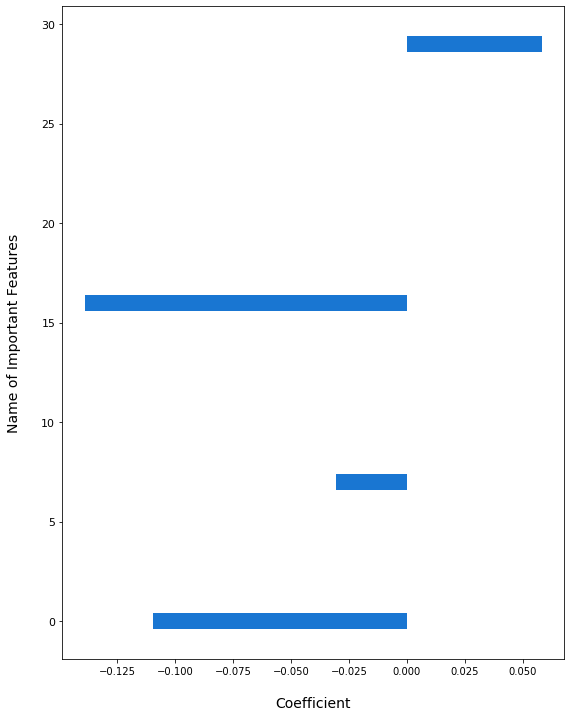

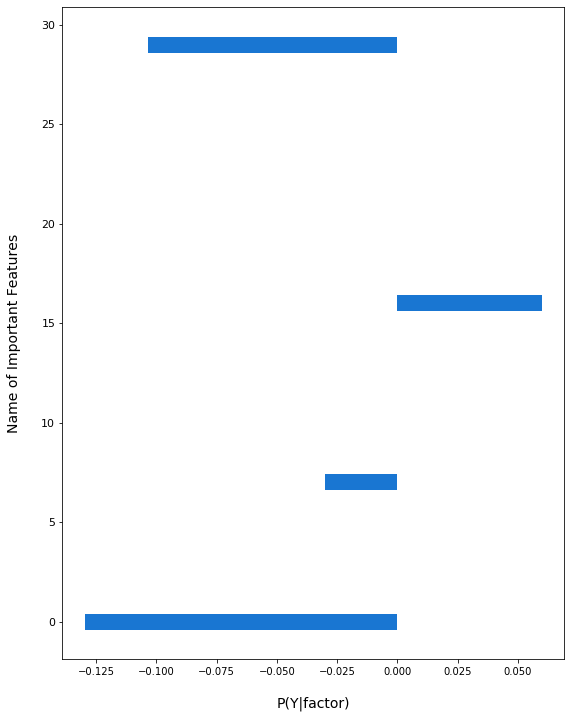

In [7]:
LASSOCV_Selection(X, Y, n_CV = 2)

# Testing Area

In [2]:
X, Y = make_classification(n_samples=1000, n_features=30, n_classes = 10, n_clusters_per_class = 1,
                           n_informative = 4, random_state = 1)

X = pd.DataFrame(X)
Y = pd.DataFrame(Y)
#print(X)
#print(Y)

In [3]:
#Test: for LASSO without CV > The optimal lamda is not defined.
lasso_no_cv = Lasso()
lasso_no_cv.fit(X, Y)
sel_n = SelectFromModel(estimator = lasso_no_cv, prefit = True, max_features = 10)

s_n = sel_n.get_support(indices = True)
print(s_n)

[ 0 16]


In [4]:
'''
tscv = TimeSeriesSplit(n_splits = 2)

lasso_selector = SelectFromModel(LassoCV(cv = tscv), max_features = 10)
lasso_selector.fit(X, Y)
'''

tscv = TimeSeriesSplit(n_splits = 3)
lasso = LassoCV(cv = tscv)
lasso.fit(X, Y)
sel = SelectFromModel(estimator = lasso, 
                          prefit = True, 
                          max_features = 10)

s = sel.get_support(indices = True)
print(s)

#print(lasso.alpha_)
#print(lasso.alphas_)

print(lasso.coef_)

[ 0  7 16 29]
[-0.42284864 -0.         -0.          0.         -0.         -0.
  0.         -0.09318465 -0.          0.          0.          0.
 -0.          0.          0.         -0.         -0.59226382 -0.
 -0.         -0.         -0.          0.         -0.         -0.
  0.         -0.         -0.          0.         -0.          0.135478  ]


C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [12]:
lasso_support = lasso_selector.get_support()     
lasso_index = lasso_selector.get_support(indices = True)
print(lasso_support)
print(lasso_index)

[ True False False False False False False  True False False False False
 False False False False  True False False False False False False False
 False False False False False  True]
[ 0  7 16 29]


In [31]:
selected_feature = X.iloc[:, lasso_index]
selected_feature1 = sm.add_constant(selected_feature) # adding a constant

poisson_model = sm.GLM(Y, selected_feature1, family = sm.families.Poisson())
result = poisson_model.fit()


In [32]:
print(result.params)

const    1.451658
0       -0.109368
7       -0.030592
16      -0.138759
29       0.058038
dtype: float64


In [35]:
result.params.values[1]

-0.10936805691225683

In [51]:
coef = []
for v in range(1, len(lasso_index)+1):
    coef.append(result.params.values[v])
    
print(coef)

coef = np.array(coef)
print(type(coef))

[-0.10936805691225683, -0.030592354163447466, -0.13875881445696495, 0.05803846899596113]
<class 'numpy.ndarray'>


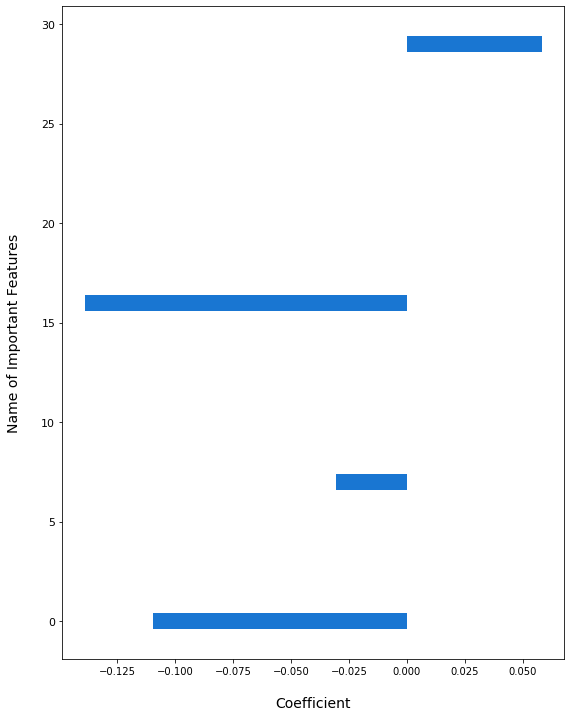

In [52]:
#Plot the estimated coefficient.
dset = pd.DataFrame()
dset['attr'] = X.columns[lasso_index]
dset['Coefficient'] = coef.T #Transform array by replacing column/row by row/column.
dset = dset.sort_values(by = 'Coefficient', ascending=False)

plt.figure(figsize = (9, 12))
plt.yticks(fontsize = 11)
plt.barh(y = dset['attr'], width = dset['Coefficient'], color = '#1976D2')
#plt.title('Test ', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Coefficient', fontsize = 14, labelpad = 20)
plt.ylabel('Name of Important Features', fontsize = 14, labelpad = 20)
plt.show()

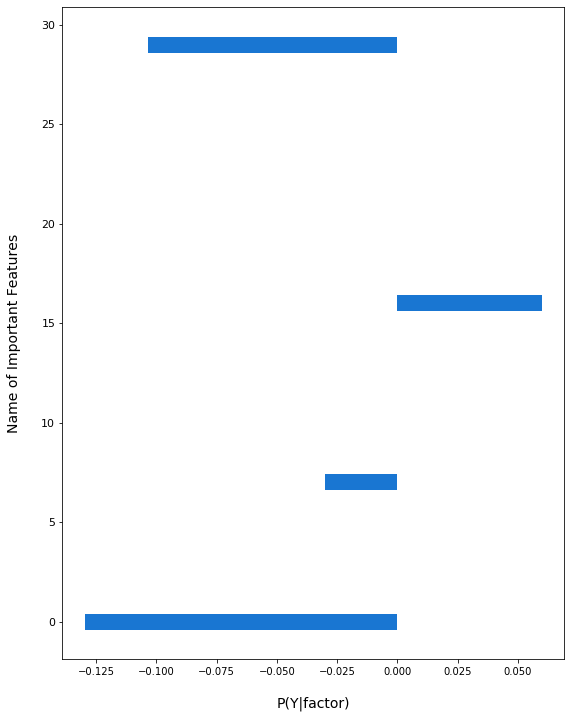

In [54]:
#Plot estimated probability
#Probability transformation: http://www.haowang.pw/blog/Poisson-Coefficient-Interpretation/
prob = []
for i in range(len(coef.T)):
    prob_value = math.exp(coef.T[i]) - 1 
    prob.append(prob_value)
    prob_arr = np.array(prob) #Must transform into array to plot against feature neame.

dset['Prob'] = prob_arr
dset = dset.sort_values(by = 'Coefficient', ascending = False)

plt.figure(figsize = (9, 12))
plt.yticks(fontsize = 11)
plt.barh(y = dset['attr'], width=dset['Prob'], color='#1976D2')
#plt.title('Test ', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('P(Y|factor)', fontsize = 14, labelpad = 20)
plt.ylabel('Name of Important Features', fontsize = 14, labelpad=20)
plt.show()
    

In [55]:
print(prob_arr)

[-0.10359957 -0.03012914 -0.12956206  0.05975576]
